#Generalized Linear Models
To run the code provided, follow the steps outlined below:

Install the required Python packages. Ensure that you have the necessary libraries such as NumPy, Matplotlib, and pandas installed. If any of these packages are missing, you can install them using pip.

Make sure to have the following CSV files in the specified directory or adjust the path in the code accordingly:

A.csv

labels-A.csv

AO.csv

AP.csv

labels-AO.csv

labels-AP.csv

usps.csv

labels-usps.csv

Run the main() function corresponding to different datasets, which will load the data, add an intercept to the data matrix, apply the GLM algorithm, and generate learning curves with error bars. The resulting learning curves will be plotted.

Ensure that you have the necessary permissions to access the files and directories specified in the code.

By following these steps, you can execute the provided Python script and generate the learning curves for the specified dataset. Adjust the parameters and file paths as needed to customize the code for your specific use case.

In [904]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Function to load data from files
def load_data(file_path):
    # Load data from file and return as a numpy array
    data = pd.read_csv(file_path)
    data_array = data.to_numpy()
    return data_array

In [905]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [906]:
# Function to add an intercept feature to the data matrix
def add_intercept(data):

    intercept = np.ones((data.shape[0], 1))
    data_with_intercept = np.concatenate((intercept, data), axis=1)
    return data_with_intercept

# Function to compute the first derivative of the log posterior (g)
def compute_first_derivative(data, labels, weights, alpha, likelihood_model):
    # calculation of g based on the likelihood model
    if likelihood_model=='logistic':
      predictions = sigmoid(np.dot(data,weights))
      predictions = predictions.reshape(-1, 1)
      d = labels - predictions


    elif likelihood_model== 'poisson':
      predictions = np.exp(np.dot(data,weights))
      d = labels - predictions

    elif likelihood_model == 'ordinal':
      phi_values = np.array([-np.inf, -2, -1, 0, 1, np.inf])
      a = np.dot(data,weights)
      y = sigmoid(1.5 * (phi_values - a))
      d = np.array([y[labels[i], labels[i - 1]] - 1 for i in range(1, len(labels))])


    g = np.dot(data.T,d) - alpha * weights

    return g

# Function to compute the second derivative of the log posterior (H)
def compute_second_derivative(data, labels, weights, alpha, likelihood_model):
    # calculation of H based on the likelihood model
    if likelihood_model=='logistic':
      predictions = sigmoid(np.dot(data,weights))
      r = predictions * (1 - predictions)

    if likelihood_model=='poisson':
      predictions = np.exp(np.dot(data,weights))
      r=predictions

    if likelihood_model=='ordinal':
      phi_values = np.array([-np.inf, -2, -1, 0, 1, np.inf])
      a = np.dot(data,weights)
      y = sigmoid(s * (phi_values - a))
      r = s ** 2 * (y[:, labels] * (1 - y[:, labels]) + y[:, labels - 1] * (1 - y[:, labels - 1]))


    R = np.diag(r.flatten())


    H = -np.dot(np.dot(data.T, R ), data) - alpha * np.identity(data.shape[1])

    return H


In [907]:
# GLM algorithm with Newton's method for convergence
def glm_algorithm(data, labels, alpha, likelihood_model):
    # Initialize the weight vector
    weights = np.zeros((data.shape[1],1))
    iterations=0

    #iterative process with Newton's method
    for i in range(100):

        # Compute g and H
        g = compute_first_derivative(data, labels, weights, alpha, likelihood_model)
        H = compute_second_derivative(data, labels, weights, alpha, likelihood_model)

        # Check the convergence condition
        if np.linalg.norm(np.dot(np.linalg.inv(H), g))**2 < 1e-3 * np.linalg.norm(weights)**2:
            break

        # Update weights with Newton's method

        weights -= np.dot(np.linalg.inv(H), g)
        iterations=iterations+1





    return weights, iterations


In [908]:
def calculate_error_rate(test_data, test_labels, weights, likelihood_model):
    error_rates = []
    for i in range(len(test_data)):
        z = test_data[i]

        if likelihood_model == 'logistic':
            p = sigmoid(np.dot( z,weights))
            predicted_label = 1 if p >= 0.5 else 0
            error = 1 if predicted_label != test_labels[i] else 0
            error_rates.append(error)
        elif likelihood_model == 'poisson':
            a = np.dot(z,weights)
            lambda_val = np.exp(a)
            predicted_label = np.vectorize(round)(lambda_val)
            error = abs(predicted_label - test_labels[i])
            error_rates.append(error)
        elif likelihood_model == 'ordinal':
            a = np.dot(z,weights)
            phi_values = np.array([-np.inf, -2, -1, 0, 1, np.inf])
            y = sigmoid(1.5 * (phi_values - a))
            y_diff = np.diff(y)
            predicted_label = np.argmax(y_diff) + 1
            error = abs(predicted_label - test_labels[i])
            error_rates.append(error)

    return error_rates


In [909]:
# Function for generating learning curves with error bars
def generate_learning_curves(data, labels, likelihood_model):
    mean_error_rates = []
    mean_error=[]
    error_rates_mean=np.zeros((30, 10))
    std_dev = []
    num_iterations = []
    run_time = []
    train_sizes=[]
    # Set the alpha value (regularization parameter)
    alpha=10

    for _ in range(30):
        # Step 1: Set aside 1/3 of the total data (randomly selected) to use as a test set
        num_data = len(data)
        test_size = num_data // 3
        indices = np.random.permutation(num_data)
        test_indices = indices[:test_size]
        train_indices = indices[test_size:]
        test_data, test_labels = data[test_indices], labels[test_indices]
        train_data, train_labels = data[train_indices], labels[train_indices]

        # Step 2: Permute the remaining data and record the test set error rate as a function of increasing training set portion
        for i in range(1, 11):

            train_size = int(i / 10 * len(train_data))
            partial_train_data, partial_train_labels = train_data[:train_size], train_labels[:train_size]

            # Apply GLM algorithm and record necessary statistics
            start_time = time.time()
            # ... (GLM algorithm implementation)
            wMAP,iterations = glm_algorithm(partial_train_data, partial_train_labels, alpha, likelihood_model)
            # ... (Record mean and standard deviation for each size)
            # ... (Record the number of iterations and the run time until convergence)
            #train_sizes.append(i/10)
            error_rate = calculate_error_rate(test_data, test_labels, wMAP, likelihood_model)
            mean_error_rates.append(np.mean(error_rate))
            error_rates_mean[_, i-1] = np.mean(error_rate)
            #std_dev.append(np.std(error_rate))
            num_iterations.append(iterations)
            end_time = time.time()
            run_time.append(end_time - start_time)

    mean_error = np.mean(error_rates_mean[:, :10], axis=0)
    for i in range(1,11):
      train_sizes.append((i)/10)
    std_dev=np.std(mean_error)




    return train_sizes, mean_error, std_dev, num_iterations, run_time

In [910]:
# Main function for each dataset
def mainA():
    # Load data
    data = load_data("/content/A.csv")
    labels = load_data("/content/labels-A.csv")


    # Add intercept to the data matrix
    data_with_intercept = add_intercept(data)


    # Generate learning curves with error bars
    train_sizes, mean_error_rates, std_dev, num_iterations, run_time = generate_learning_curves(data_with_intercept, labels, 'logistic')
    print(f"Runtime for A data = {np.mean(run_time)}")
    print(f"Iterations for A data={np.mean(num_iterations)}")
    # Plot the learning curves with error bars
    plt.errorbar(train_sizes, mean_error_rates, yerr=std_dev, label='Learning Curves',ecolor='Black',color='Blue')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('Learning Curves with Error Bars- A data')
    plt.legend()
    plt.show()


In [911]:
def mainusps():
    # Load data
    data = load_data("/content/usps.csv")
    labels = load_data("/content/labels-usps.csv")

    # Add intercept to the data matrix
    data_with_intercept = add_intercept(data)


    # Generate learning curves with error bars
    train_sizes, mean_error_rates, std_dev, num_iterations, run_time = generate_learning_curves(data_with_intercept, labels, 'logistic')
    print(f"Runtime for usps data = {np.mean(run_time)}")
    print(f"Iterations for usps data={np.mean(num_iterations)}")
    # Plot the learning curves with error bars
    plt.errorbar(train_sizes, mean_error_rates, yerr=std_dev, label='Learning Curves',ecolor='Black',color='Blue')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('Learning Curves with Error Bars-usps data')
    plt.legend()
    plt.show()

In [912]:
def mainAP():
    # Load data
    data = load_data("/content/AP.csv")
    labels = load_data("/content/labels-AP.csv")

    # Add intercept to the data matrix
    data_with_intercept = add_intercept(data)


    # Generate learning curves with error bars
    train_sizes, mean_error_rates, std_dev, num_iterations, run_time = generate_learning_curves(data_with_intercept, labels, 'poisson')
    print(f"Runtime for AP data = {np.mean(run_time)}")
    print(f"Iterations for AP data={np.mean(num_iterations)}")
    # Plot the learning curves with error bars
    plt.errorbar(train_sizes, mean_error_rates, yerr=std_dev, label='Learning Curves',ecolor='Black',color='Blue')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('Learning Curves with Error Bars- AP data')
    plt.legend()
    plt.show()

In [913]:
def mainAO():
    # Load data
    data = load_data("/content/AO.csv")
    labels = load_data("/content/labels-AO.csv")

    # Add intercept to the data matrix
    data_with_intercept = add_intercept(data)


    # Generate learning curves with error bars
    train_sizes, mean_error_rates, std_dev, num_iterations, run_time = generate_learning_curves(data_with_intercept, labels, 'poisson')
    print(f"Runtime for AO data = {np.mean(run_time)}")
    print(f"Iterations for AO data={np.mean(num_iterations)}")

    # Plot the learning curves with error bars
    plt.errorbar(train_sizes, mean_error_rates, yerr=std_dev, label='Learning Curves',color='Blue',ecolor='Black')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('Learning Curves with Error Bars- AO data')
    plt.legend()
    plt.show()

Runtime for A data = 0.03426956335703532
Iterations for A data=1.4333333333333333


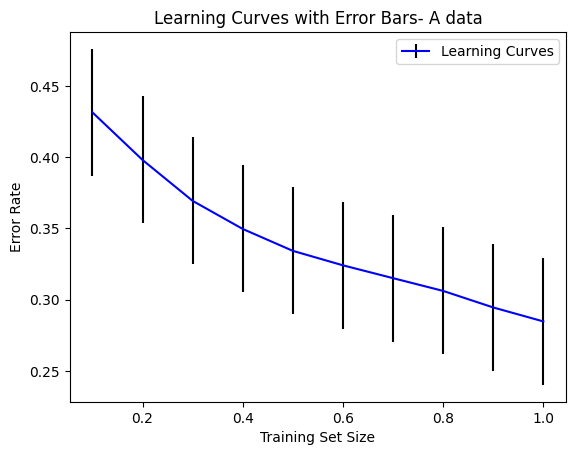

Runtime for usps data = 0.13522712310155233
Iterations for usps data=4.316666666666666


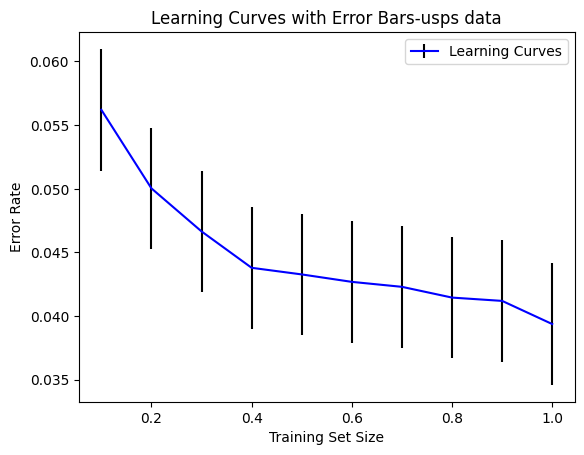

Runtime for AP data = 0.08025397300720215
Iterations for AP data=5.49


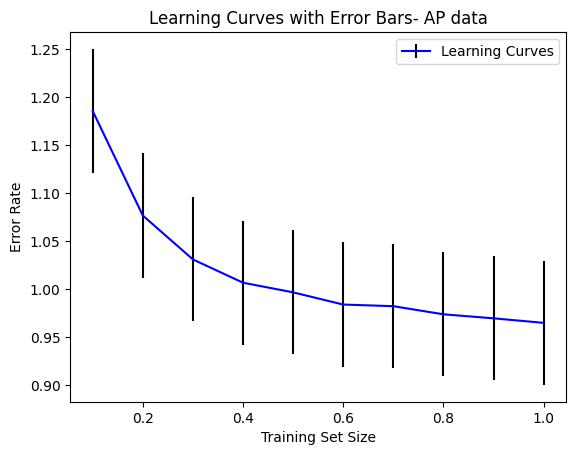

Runtime for AO data = 0.061428967316945395
Iterations for AO data=4.0


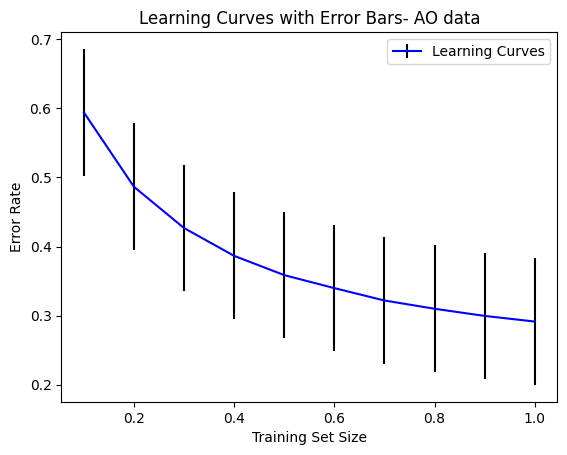

In [914]:
mainA()
mainusps()
mainAP()
mainAO()